## The clean code

Historical gasoline price data in Germany as CSV files. The prices are made available by Tankerkönig as a data collection, in the following URL: *https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data*. This is a commercial repository. The data is in the following format:

| Field         | Meaning                                      |
|---------------|----------------------------------------------|
| date          | Date of modification                         |
| station_uuid  | UUID of the petrol station stations          |
| diesel        | Price Diesel                                 |
| E5            | Price Super E5                               |
| E10           | Price Super E10                              |
| dieselchange  | 0=no change, 1=change, 2=removed, 3=new      |
| e5change      | 0=no change, 1=change, 2=removed, 3=new      |
| e10change     | 0=no change, 1=change, 2=removed, 3=new      |

After that, the objective was to aggregate the daily price data in Germany. The next code exposes the process for collecting this kind of data. Nevertheless, the way this data is treated could be discussed with the Thesis director.


In [ ]:
import pandas as pd
import glob
import os
 
def process_month(year, month, base_path):
    # Construct the file path pattern
    file_path_pattern = os.path.join(base_path, f'{year}', f'{month:02d}', '*-prices.csv')
    file_paths = glob.glob(file_path_pattern)
    if not file_paths:
        print(f"No CSV files found for {year}-{month:02d}")
        return pd.DataFrame()  # Return an empty DataFrame if no files found
 
    # Read all CSV files and concatenate them into a single DataFrame
    df_list = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
 
    if not df_list:
        print(f"No dataframes created for {year}-{month:02d}")
        return pd.DataFrame()  # Return an empty DataFrame if no dataframes created
 
    combined_df = pd.concat(df_list, ignore_index=True)
    # Convert 'date' column to datetime, ensuring UTC timezone
    combined_df['date'] = pd.to_datetime(combined_df['date'], errors='coerce', utc=True)
    # Drop rows where 'date' conversion failed
    combined_df = combined_df.dropna(subset=['date'])
    # Extract just the day from the 'date' column
    combined_df['date'] = combined_df['date'].dt.date
    # Convert price columns to numeric, coercing errors
    price_columns = ['diesel', 'e5', 'e10']
    combined_df[price_columns] = combined_df[price_columns].apply(pd.to_numeric, errors='coerce')
    # Group by 'date' and calculate the mean for each price column
    return combined_df.groupby('date')[price_columns].mean().reset_index()
 
def process_year(year, base_path):
    monthly_averages = []
    for month in range(1, 13):
        monthly_avg = process_month(year, month, base_path)
        if not monthly_avg.empty:
            monthly_averages.append(monthly_avg)
        else:
            print(f"No data for {year}-{month:02d}")
    if not monthly_averages:
        print(f"No monthly data for year {year}")
        return pd.DataFrame()  # Return an empty DataFrame if no monthly data
 
    return pd.concat(monthly_averages, ignore_index=True)
 
def process_multiple_years(years, base_path):
    yearly_averages = []
    for year in years:
        yearly_avg = process_year(year, base_path)
        if not yearly_avg.empty:
            yearly_avg['year'] = year  # Add a 'year' column for distinction
            yearly_averages.append(yearly_avg)
        else:
            print(f"No data for year {year}")
    if not yearly_averages:
        raise ValueError("No data available for the provided years")
 
    return pd.concat(yearly_averages, ignore_index=True)
 
# Base path to the data files
base_path = r'~local_file'
 
# Process multiple years and combine into one DataFrame
years_to_process = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
combined_data = process_multiple_years(years_to_process, base_path)
 
# Print the combined data
print(combined_data.head())

## Import and export for state and price

In [ ]:
import pandas as pd
import glob
import os

def process_month(year, month, base_path, stations_df):
    # Construct the file path pattern
    file_path_pattern = os.path.join(base_path, f'{year}', f'{month:02d}', '*-prices.csv')
    file_paths = glob.glob(file_path_pattern)
    if not file_paths:
        print(f"No CSV files found for {year}-{month:02d}")
        return pd.DataFrame()  # Return an empty DataFrame if no files found

    # Read all CSV files and concatenate them into a single DataFrame
    df_list = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    if not df_list:
        print(f"No dataframes created for {year}-{month:02d}")
        return pd.DataFrame()  # Return an empty DataFrame if no dataframes created

    combined_df = pd.concat(df_list, ignore_index=True)
    # Convert 'date' column to datetime, ensuring UTC timezone
    combined_df['date'] = pd.to_datetime(combined_df['date'], errors='coerce', utc=True)
    # Drop rows where 'date' conversion failed
    combined_df = combined_df.dropna(subset=['date'])
    # Extract just the day from the 'date' column
    combined_df['date'] = combined_df['date'].dt.date
    # Convert price columns to numeric, coercing errors
    price_columns = ['diesel', 'e5', 'e10']
    combined_df[price_columns] = combined_df[price_columns].apply(pd.to_numeric, errors='coerce')

    # Merge with stations_df to add state information
    combined_df = pd.merge(combined_df, stations_df[['station_uuid', 'State']], on='station_uuid', how='left')
    
    # Group by 'date' and 'State' and calculate the mean for each price column
    return combined_df.groupby(['date', 'State'])[price_columns].mean().reset_index()

def process_year(year, base_path, stations_df):
    monthly_averages = []
    for month in range(1, 13):
        monthly_avg = process_month(year, month, base_path, stations_df)
        if not monthly_avg.empty:
            monthly_averages.append(monthly_avg)
        else:
            print(f"No data for {year}-{month:02d}")
    if not monthly_averages:
        print(f"No monthly data for year {year}")
        return pd.DataFrame()  # Return an empty DataFrame if no monthly data

    return pd.concat(monthly_averages, ignore_index=True)

def process_multiple_years(years, base_path, stations_df):
    yearly_averages = []
    for year in years:
        yearly_avg = process_year(year, base_path, stations_df)
        if not yearly_avg.empty:
            yearly_avg['year'] = year  # Add a 'year' column for distinction
            yearly_averages.append(yearly_avg)
        else:
            print(f"No data for year {year}")
    if not yearly_averages:
        raise ValueError("No data available for the provided years")

    return pd.concat(yearly_averages, ignore_index=True)

# Load the stations data with state information
stations_df = pd.read_csv(r'~local_file', encoding='latin1', delimiter=';')

# Base path to the data files
base_path = r'~local_file'

# Process multiple years and combine into one DataFrame
years_to_process = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
price_state = process_multiple_years(years_to_process, base_path, stations_df)

# Export the combined data to a CSV file
output_path = r'~local_file\price_state.csv'
price_state.to_csv(output_path, index=False)

# Print the combined data
print(price_state.head())


No CSV files found for 2024-07
No data for 2024-07
No CSV files found for 2024-08
No data for 2024-08
No CSV files found for 2024-09
No data for 2024-09
No CSV files found for 2024-10
No data for 2024-10
No CSV files found for 2024-11
No data for 2024-11
No CSV files found for 2024-12
No data for 2024-12
         date              State    diesel        e5       e10  year
0  2017-12-31  Baden-Württemberg  1.171667  1.232400  1.028533  2018
1  2017-12-31             Bayern  1.275413  1.375565  1.355565  2018
2  2017-12-31             Berlin  1.239000  1.419000  1.399000  2018
3  2017-12-31        Brandenburg  1.309000  1.479000  1.459000  2018
4  2017-12-31             Hessen  1.227000  1.393250  1.252708  2018


In [ ]:
price_state

,date,State,diesel,e5,e10,year
0,2017-12-31,Baden-Württemberg,1.171667,1.232400,1.028533,2018
1,2017-12-31,Bayern,1.275413,1.375565,1.355565,2018
2,2017-12-31,Berlin,1.239000,1.419000,1.399000,2018
3,2017-12-31,Brandenburg,1.309000,1.479000,1.459000,2018
4,2017-12-31,Hessen,1.227000,1.393250,1.252708,2018
...,...,...,...,...,...,...
38677,2024-06-04,Saarland,1.615992,1.814352,1.728005,2024
38678,2024-06-04,Sachsen,1.659783,1.814377,1.711992,2024
38679,2024-06-04,Sachsen-Anhalt,1.626585,1.762439,1.658551,2024
38680,2024-06-04,Schleswig-Holstein,1.643407,1.815078,1.698289,2024


# Coding that include Id Gas Stations

## The preliminar data base for pricing for the national prices ##

Because of the size of the data process in the previous step, i already save the data, in order to let this data to be ready for analized.

In [ ]:
# Export the combined data to a CSV file
output_path = os.path.join(base_path, 'combined_data.csv')
combined_data.to_csv(output_path, index=False)

#### Descriptives statistics

            diesel           e5          e10         year
count  2425.000000  2425.000000  2425.000000  2425.000000
mean      1.467708     1.579067     1.492150  2020.733608
std       0.302359     0.237081     0.217320     1.867066
min       1.021571     1.138377     1.048899  2018.000000
25%       1.249389     1.385532     1.324800  2019.000000
50%       1.344038     1.516561     1.443826  2021.000000
75%       1.709427     1.790759     1.680818  2022.000000
max       2.331637     2.226820     2.105457  2024.000000


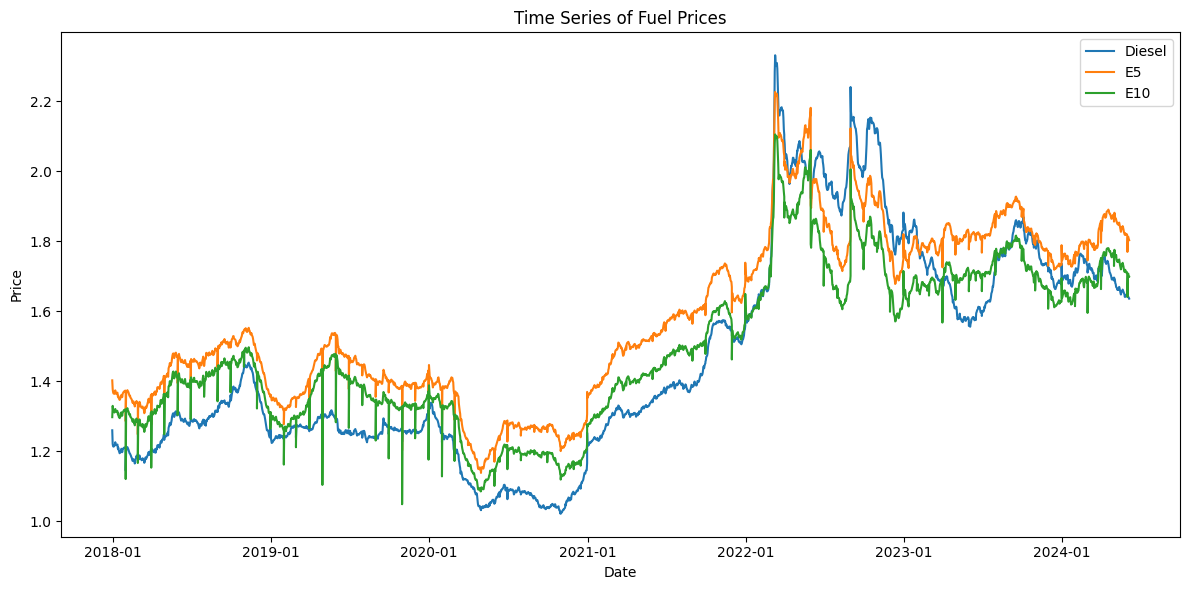

<Figure size 1400x700 with 0 Axes>

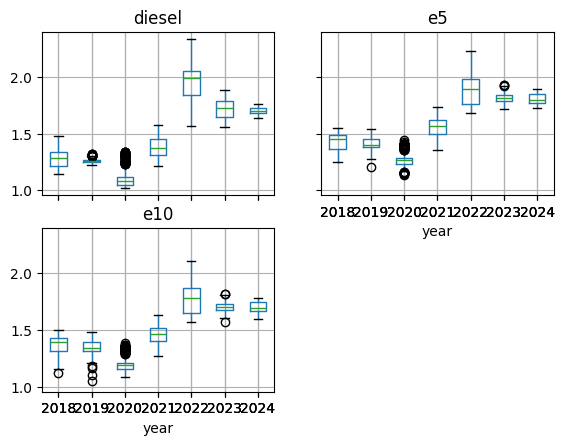

<Figure size 1400x700 with 0 Axes>

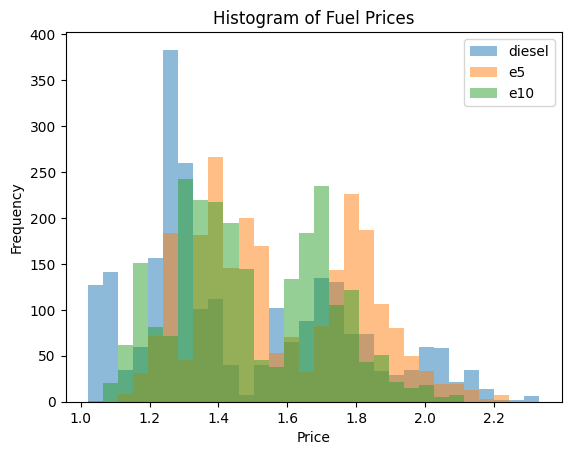

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def load_data(file_path):
    """Load the CSV data file."""
    return pd.read_csv(file_path)

def compute_basic_statistics(data):
    """Compute basic statistics of the data."""
    return data.describe()

def plot_time_series(data):
    """Plot the time series of fuel prices."""
    data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is in datetime format

    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['diesel'], label='Diesel')
    plt.plot(data['date'], data['e5'], label='E5')
    plt.plot(data['date'], data['e10'], label='E10')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Time Series of Fuel Prices')
    plt.legend()

    # Format the x-axis to show fewer date ticks
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_boxplot_by_year(data):
    """Plot the boxplot of fuel prices by year."""
    plt.figure(figsize=(14, 7))
    data.boxplot(column=['diesel', 'e5', 'e10'], by='year')
    plt.title('Boxplot of Fuel Prices by Year')
    plt.suptitle('')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.show()

def plot_histogram(data):
    """Plot the histogram of fuel prices."""
    plt.figure(figsize=(14, 7))
    data[['diesel', 'e5', 'e10']].plot(kind='hist', alpha=0.5, bins=30)
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.title('Histogram of Fuel Prices')
    plt.show()

    # Load the uploaded data
file_path = r'~local_file\combined_data.csv'
combined_data = load_data(file_path)

    # Basic statistics
basic_stats = compute_basic_statistics(combined_data)
print(basic_stats)

    # Plotting
plot_time_series(combined_data)
plot_boxplot_by_year(combined_data)
plot_histogram(combined_data)




#### Line Chart

Overall Trends: All three fuel types show a general increase in prices over the given time period, with significant fluctuations.
Price Spikes: There are notable spikes in prices around early 2022, which affect all three types of fuel. This suggests a significant event or series of events impacting fuel prices globally or regionally during that time.
Relative Pricing: E5 consistently remains the most expensive fuel type, followed by E10, with Diesel being the least expensive of the three.
Seasonal Patterns: There appear to be seasonal fluctuations in fuel prices, particularly noticeable in the earlier years (2018-2020), where periodic peaks and troughs can be seen.
Recent Stability: From late 2022 onwards, prices for all three fuel types seem to show less volatility and more stable trends compared to the previous years, though they remain higher than the prices observed before 2021.


### Histogram

Diesel Prices: Diesel prices are heavily concentrated between 1.2 and 1.4, with a significant peak around 1.2. There are fewer occurrences of diesel prices above 1.6.
E5 Prices: E5 prices show a broader distribution compared to diesel. The majority of the prices fall between 1.3 and 1.8, with notable peaks around 1.4 and 1.7.
E10 Prices: E10 prices have a distribution similar to E5 but slightly more concentrated between 1.3 and 1.7. There is a significant peak around 1.4.
Price Comparison: E5 generally has higher prices than E10 and diesel, as evident from the higher frequency of occurrences at higher price points.
Distribution Spread: Diesel prices are more tightly clustered, while E5 and E10 prices show a broader spread, indicating more variability in their pricing.

C:\Users\mauro\AppData\Local\Temp\ipykernel_10732\1616107964.py:23: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.boxplot(column=['diesel', 'e5', 'e10'], by='year', ax=axes[1])


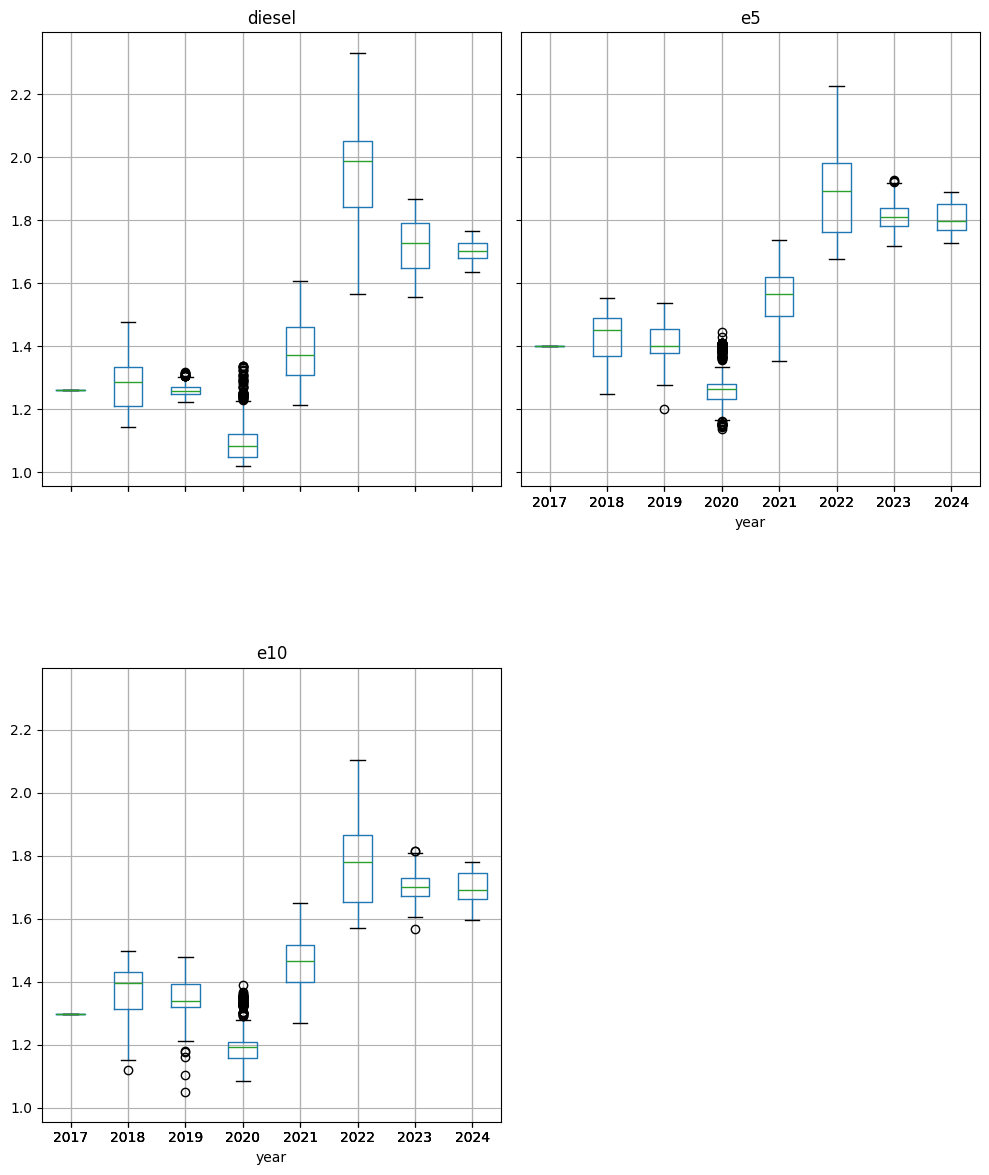

,date,diesel,e5,e10,year
count,2425,2425.000000,2425.000000,2425.000000,2425.000000
mean,2021-03-18 21:39:15.958762752,1.467708,1.579067,1.492150,2020.730722
min,2017-12-31 00:00:00,1.021571,1.138377,1.048899,2017.000000
25%,2019-08-10 00:00:00,1.249389,1.385532,1.324800,2019.000000
50%,2021-03-19 00:00:00,1.344038,1.516561,1.443826,2021.000000
75%,2022-10-27 00:00:00,1.709427,1.790759,1.680818,2022.000000
max,2024-06-04 00:00:00,2.331637,2.226820,2.105457,2024.000000
std,NaN,0.302359,0.237081,0.217320,1.867425


In [ ]:
def plot_combined(data):
    """Plot all charts in a single frame with subplots."""
    data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is in datetime format

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

    # Plot 1: Time series plot of average prices
    axes[0].plot(data['date'], data['diesel'], label='Diesel')
    axes[0].plot(data['date'], data['e5'], label='E5')
    axes[0].plot(data['date'], data['e10'], label='E10')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Price')
    axes[0].set_title('Time Series of Fuel Prices')
    axes[0].legend()
    axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(45)

    # Plot 2: Boxplot of prices by year
    years = data['date'].dt.year
    data['year'] = years
    data.boxplot(column=['diesel', 'e5', 'e10'], by='year', ax=axes[1])
    axes[1].set_title('Boxplot of Fuel Prices by Year')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Price')
    fig.suptitle('')

    # Plot 3: Histogram of prices
    data[['diesel', 'e5', 'e10']].plot(kind='hist', alpha=0.5, bins=30, ax=axes[2])
    axes[2].set_xlabel('Price')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Histogram of Fuel Prices')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()



    # Basic statistics
basic_stats = compute_basic_statistics(combined_data)

    # Plotting
plot_combined(combined_data)
basic_stats


The box plots of fuel prices for Diesel, E5, and E10 across different years provide a detailed view of the yearly price distributions and variations. Here are the key observations and conclusions:

Overall Trend:

All three fuel types show an upward trend in prices over the years, with a significant rise observed around 2021-2022.
Diesel:

Diesel prices remained relatively stable with low variance from 2017 to 2020.
A sharp increase is noticeable in 2021, with higher variability in prices.
The highest median price is observed in 2022, with the interquartile range (IQR) being wider, indicating greater price variability.
Prices show a slight decline in 2023 and 2024 compared to 2022, but remain higher than pre-2021 levels.
E5:

E5 prices exhibit more variability year-over-year compared to Diesel.
A noticeable price increase occurs in 2021, with a further sharp increase and higher variance in 2022.
Similar to Diesel, E5 prices peak in 2022 and stabilize slightly in 2023 and 2024 but at a higher level than pre-2021.
E10:

E10 follows a pattern similar to E5, with stable prices and low variability until 2020.
A significant price rise is observed starting in 2021, peaking in 2022 with high variability.
Post-2022, E10 prices show stabilization but remain elevated compared to earlier years.
Comparison Across Fuel Types:

E5 generally has higher median prices compared to Diesel and E10 in most years.
E10 prices are closer to E5 prices, particularly from 2021 onwards, whereas Diesel remains the cheapest option.
The variability in E5 prices is greater than in Diesel and E10, as shown by the wider IQR in the box plots for several years.
In summary, the box plots indicate that fuel prices for Diesel, E5, and E10 have all increased significantly since 2021, with 2022 being a peak year for price volatility and levels. E5 remains the most expensive and variable in terms of pricing, while Diesel is the least expensive and has the lowest variability in prices.

## Analize per state ##

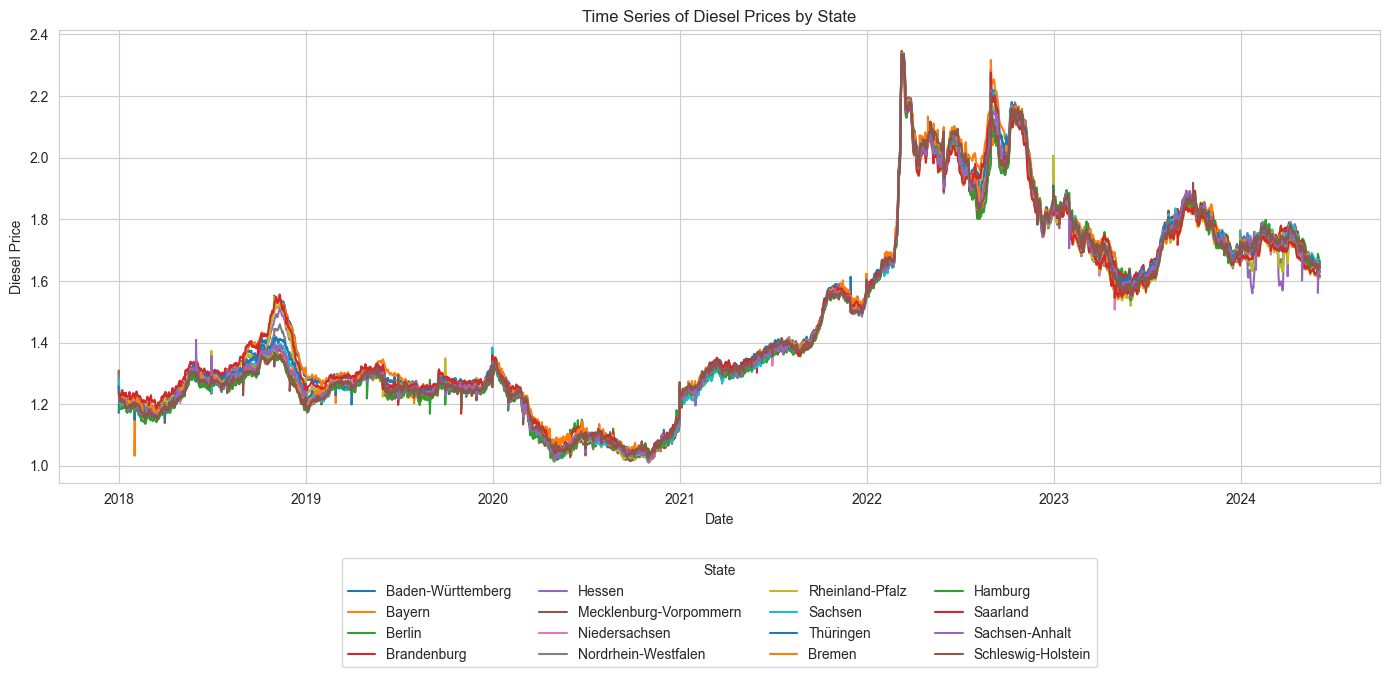

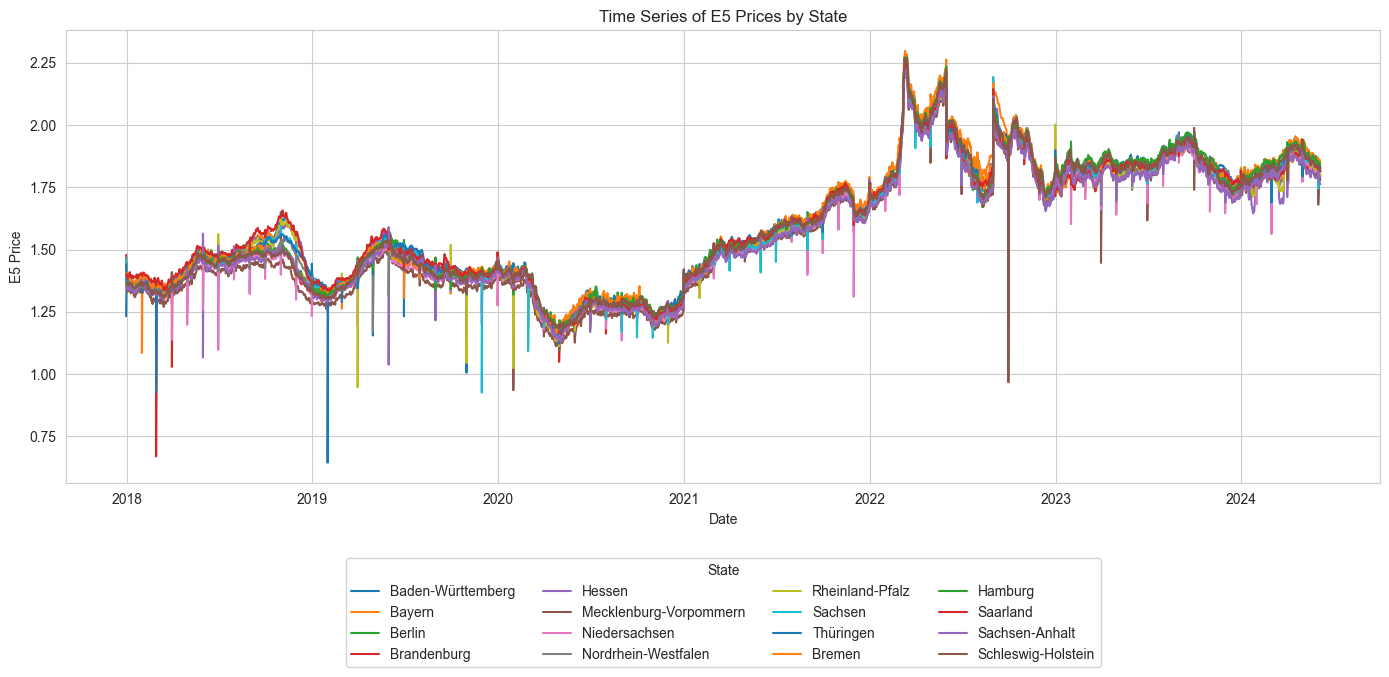

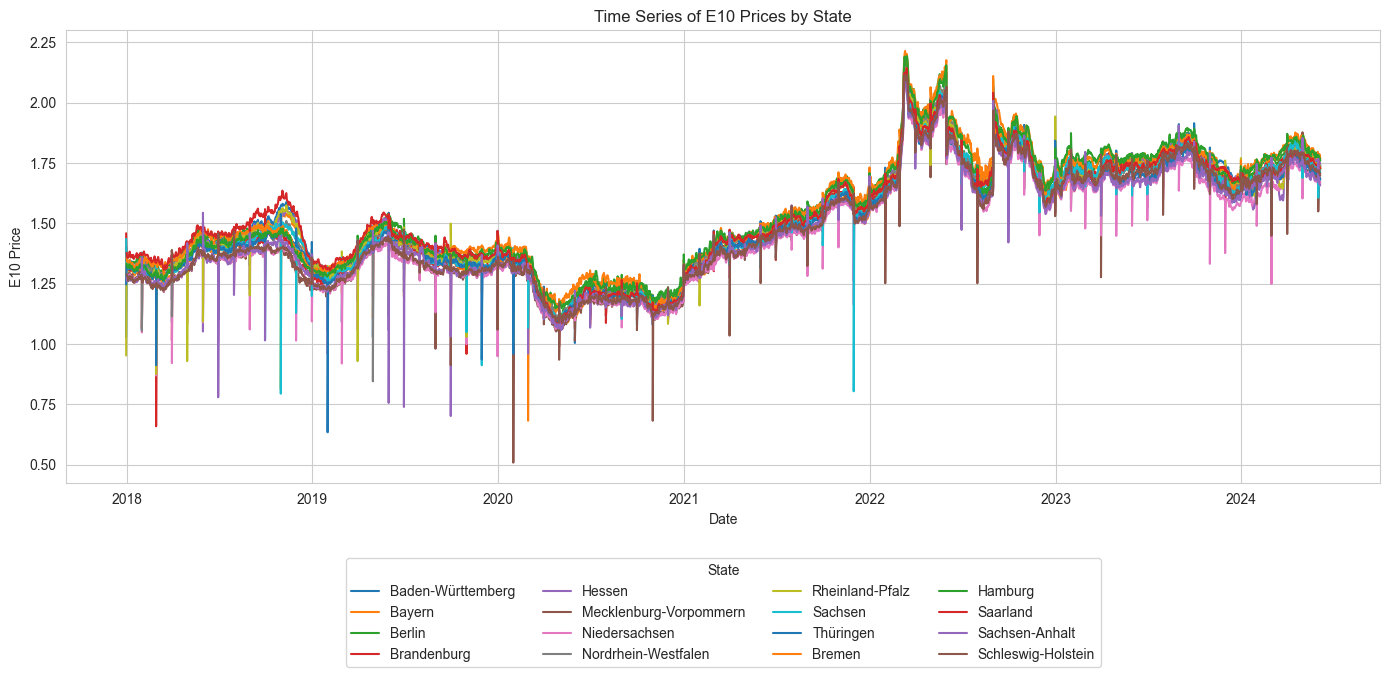

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined data
price_state = pd.read_csv(r'C:\Users\mauro\Documentos\Universidad\6. Thesis\Data\price_state_cleaned.csv')

# Convert 'date' column back to datetime
price_state['date'] = pd.to_datetime(price_state['date'])

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# 1. Time Series Plot of Fuel Prices by State
def plot_time_series(data, fuel_type):
    plt.figure(figsize=(14, 7))
    for state in data['State'].unique():
        state_data = data[data['State'] == state]
        plt.plot(state_data['date'], state_data[fuel_type], label=state)
    plt.title(f'Time Series of {fuel_type.capitalize()} Prices by State')
    plt.xlabel('Date')
    plt.ylabel(f'{fuel_type.capitalize()} Price')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), title='State', ncol=4)
    plt.tight_layout()
    plt.show()

# Plot time series for diesel, e5, and e10
plot_time_series(price_state, 'diesel')
plot_time_series(price_state, 'e5')
plot_time_series(price_state, 'e10')



The analysis reveals that fuel prices have undergone significant changes from 2018 to 2024. Key states such as Baden-Württemberg, Bayern, Berlin, Hamburg, and Nordrhein-Westfalen exhibit similar trends with peaks around 2022, indicating strong external influences on fuel prices, such as global oil price changes, supply chain disruptions, and policy changes.

The analysis of the fuel price trends in Germany reveals that diesel, E5, and E10 prices have undergone significant changes over the last six years. The sharp increase in prices around 2020-2022 highlights the impact of global and local factors on fuel prices. Diesel prices show less state-wise variation, while E5 and E10 are more sensitive to local dynamics. Understanding these trends can help policymakers and consumers make informed decisions regarding fuel consumption and pricing strategies.

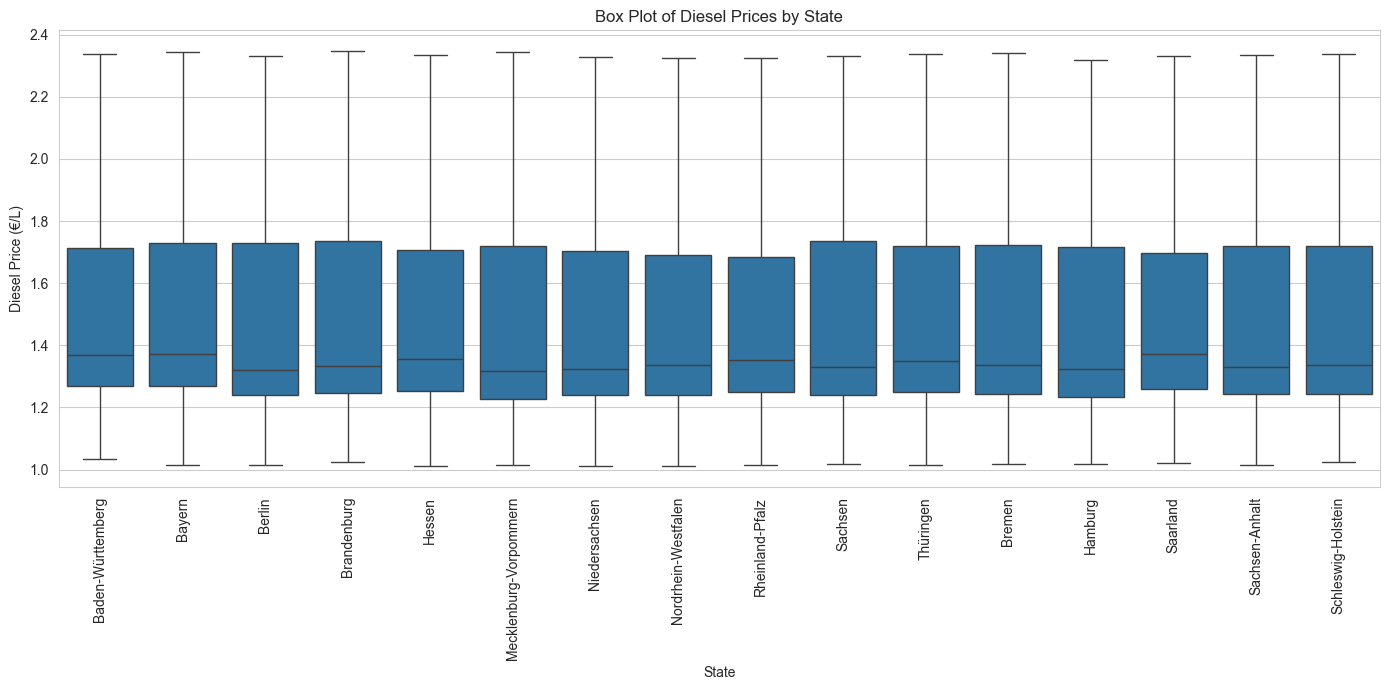

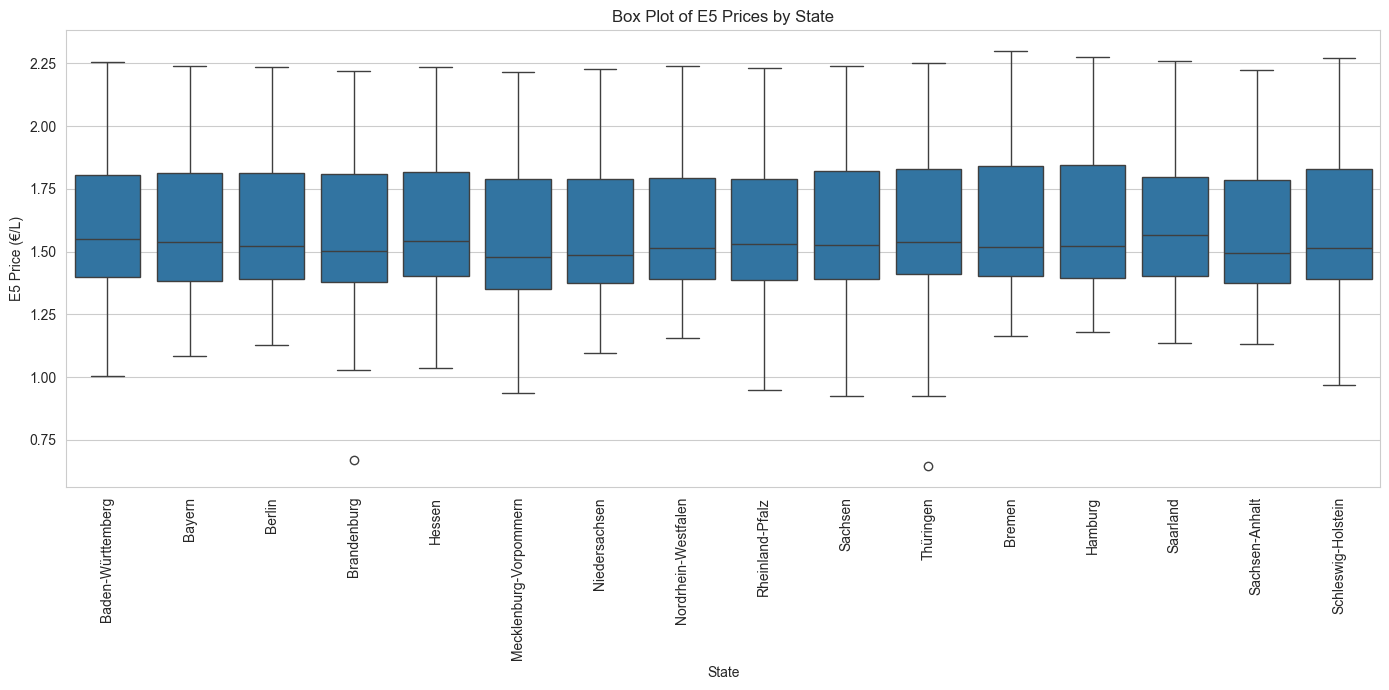

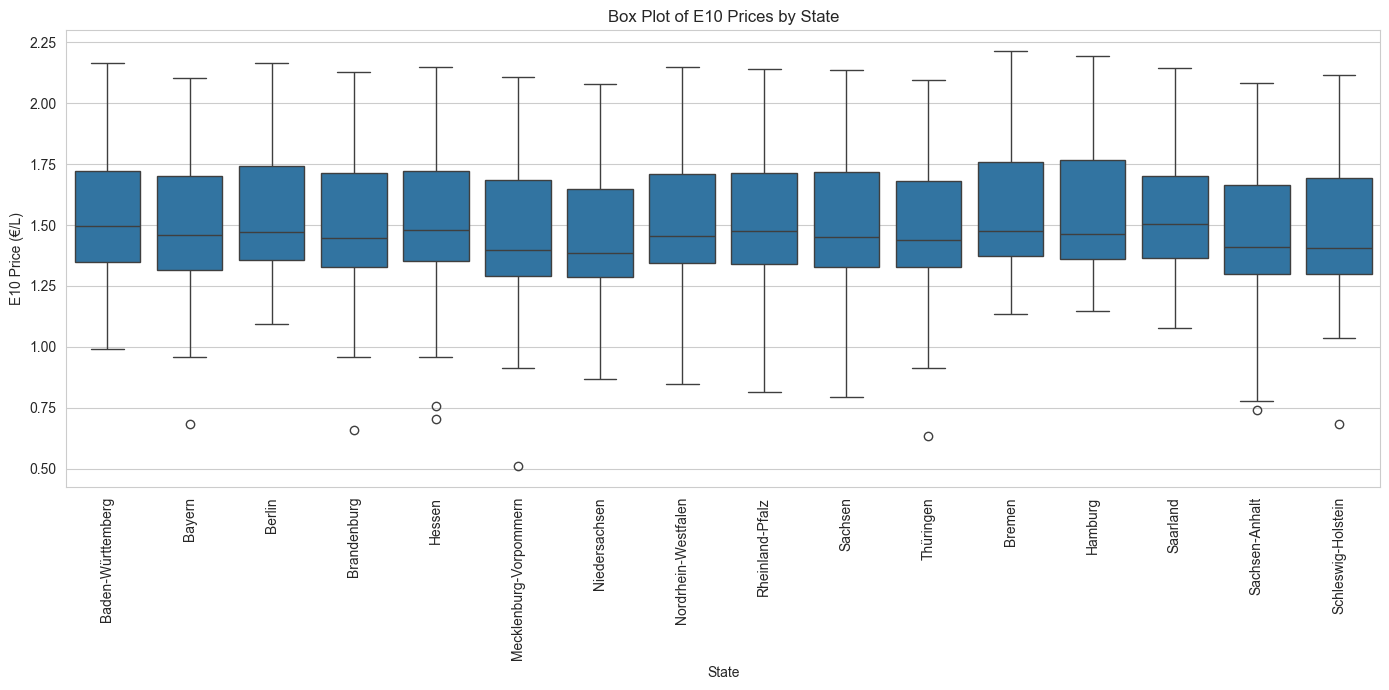

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
price_state = pd.read_csv(r'~local_file\price_state_cleaned.csv')

# Convert 'date' column to datetime
price_state['date'] = pd.to_datetime(price_state['date'])

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Function to plot box plots for each fuel type
def plot_boxplot(data, fuel_type):
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='State', y=fuel_type, data=data)
    plt.title(f'Box Plot of {fuel_type.capitalize()} Prices by State')
    plt.xlabel('State')
    plt.ylabel(f'{fuel_type.capitalize()} Price (€/L)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot box plots for diesel, e5, and e10
plot_boxplot(price_state, 'diesel')
plot_boxplot(price_state, 'e5')
plot_boxplot(price_state, 'e10')


# Analysis of Fuel Prices in Germany (2018-2024)

The following analysis is based on the box plots for diesel, E5, and E10 prices in different German states. The prices are in euros per liter and provide insights into the distribution, central tendency, and variability of fuel prices.

## Diesel Prices


1. **Central Tendency**:
   - The median diesel prices (horizontal line inside each box) are relatively consistent across states, indicating a similar central tendency.
   - The median price is around 1.4 to 1.5 €/L for most states.

2. **Variability**:
   - The interquartile range (IQR), represented by the height of the boxes, shows the middle 50% of the data.
   - Some states, like Bremen and Hamburg, show slightly wider boxes, indicating higher variability in diesel prices.
   - Most states have similar IQRs, reflecting comparable price fluctuations.

3. **Outliers**:
   - There are no significant outliers visible in the diesel price plot, suggesting that most price variations fall within expected ranges.

## E5 Prices


1. **Central Tendency**:
   - The median E5 prices are higher than diesel prices, around 1.5 to 1.6 €/L for most states.
   - The central tendency is relatively consistent across states.

2. **Variability**:
   - The IQR is slightly wider for E5 prices compared to diesel, indicating more variability.
   - States like Sachsen and Niedersachsen show broader IQRs, suggesting higher price dispersion.

3. **Outliers**:
   - Outliers are present in states like Hessen and Thüringen, indicated by points outside the whiskers.
   - These outliers could represent temporary price spikes or drops due to supply chain issues or other local factors.

## E10 Prices


1. **Central Tendency**:
   - The median E10 prices are generally lower than E5 prices, around 1.4 to 1.5 €/L.
   - The median prices are fairly consistent across states, reflecting a common pricing pattern.

2. **Variability**:
   - The IQR for E10 prices shows more variability than diesel but similar to E5.
   - States like Bremen and Hamburg again show wider IQRs, indicating more significant price fluctuations.

3. **Outliers**:
   - Several outliers are present, notably in states like Berlin and Hessen.
   - These outliers suggest occasional extreme prices, which might be due to regional supply-demand imbalances or other market dynamics.

## Key Observations

1. **Consistency Across States**:
   - All fuel types show a consistent median price across most states, suggesting that national factors heavily influence fuel pricing.
   - The IQRs are also relatively similar, indicating comparable variability in prices.

2. **Variability**:
   - Diesel prices are the least variable, while E5 and E10 prices show more fluctuation.
   - States with significant industrial or transportation activities, such as Hamburg, show more variability in prices.

3. **Outliers**:
   - The presence of outliers in E5 and E10 prices indicates occasional extreme price events, which could be due to local market conditions, supply chain disruptions, or regulatory changes.

## Conclusion

The box plots for diesel, E5, and E10 prices across different German states reveal important insights into fuel price distribution and variability. While median prices are consistent across states, indicating strong national influences, the variability and presence of outliers highlight regional differences. Diesel prices are more stable, whereas E5 and E10 exhibit more fluctuations and occasional extreme prices. Understanding these patterns can help in formulating policies and strategies to manage fuel prices effectively across regions.


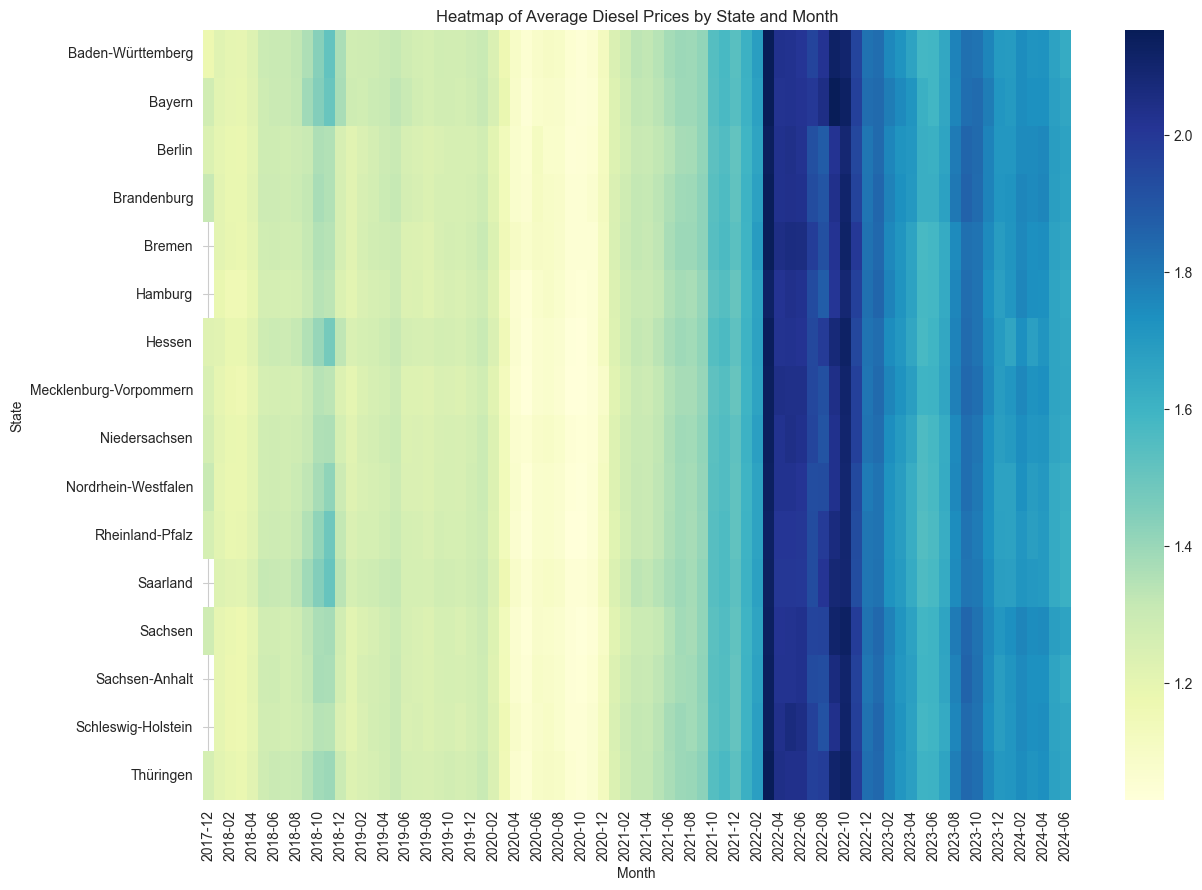

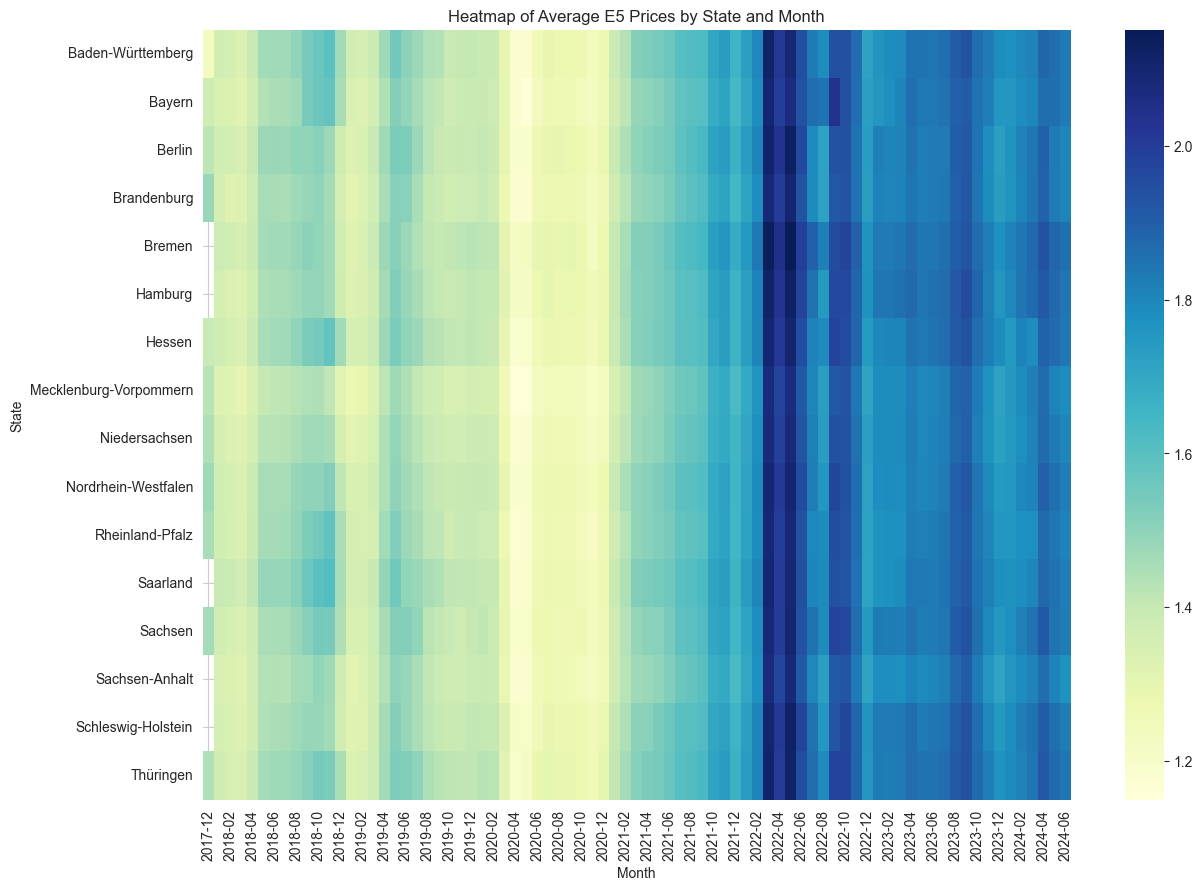

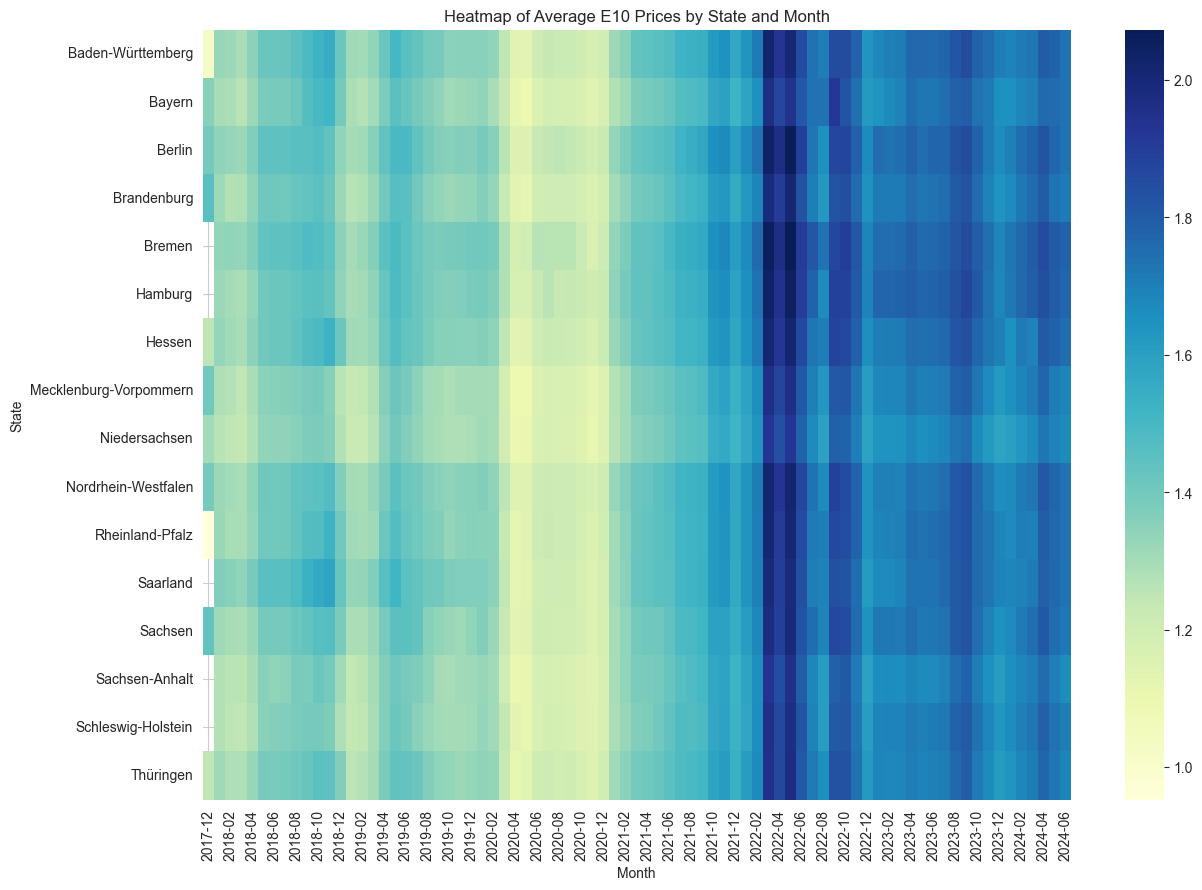

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
price_state = pd.read_csv(r'~local_file\price_state_cleaned.csv')

# Convert 'date' column to datetime
price_state['date'] = pd.to_datetime(price_state['date'])

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Function to plot heatmaps for each fuel type
def plot_heatmap(data, fuel_type):
    # Pivot the data to create a matrix for the heatmap
    pivot_table = data.pivot_table(values=fuel_type, index='State', columns=data['date'].dt.to_period('M'), aggfunc='mean')
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_table, cmap="YlGnBu", annot=False)
    plt.title(f'Heatmap of Average {fuel_type.capitalize()} Prices by State and Month')
    plt.xlabel('Month')
    plt.ylabel('State')
    plt.show()

# Plot heatmaps for diesel, e5, and e10
plot_heatmap(price_state, 'diesel')
plot_heatmap(price_state, 'e5')
plot_heatmap(price_state, 'e10')


### Analysis of Diesel Prices Heatmap

The heatmap for diesel prices across different German states provides a visual representation of average monthly prices over time. Here's a detailed analysis based on the heatmap:

#### Key Observations

1. **Overall Trend**:
   - Diesel prices show significant variation over the observed period.
   - There is a noticeable increase in prices around early 2021, peaking in 2022.

2. **High Price Periods**:
   - The dark blue regions around 2021-2022 indicate periods of high diesel prices.
   - This period corresponds to global economic disruptions, likely influenced by the COVID-19 pandemic and subsequent recovery phases.

3. **Low Price Periods**:
   - The lighter yellow regions indicate periods of lower diesel prices.
   - Notable low price periods are seen before 2020.

4. **State Comparisons**:
   - States like Bayern, Nordrhein-Westfalen, and Hessen show similar trends, indicating that diesel prices are influenced by national factors.
   - Minor variations between states suggest local factors also play a role in pricing.

5. **Seasonal Patterns**:
   - There are some recurring patterns where prices seem to rise or fall at certain times of the year, indicating potential seasonal effects on diesel prices.

#### Detailed Observations by State

1. **Baden-Württemberg**:
   - Consistent price increases, peaking around 2021-2022.
   - Prices stabilize but remain higher post-2022 compared to pre-2020 levels.

2. **Bayern**:
   - Similar trend to Baden-Württemberg with high prices during 2021-2022.
   - Minor variations indicating local market effects.

3. **Berlin**:
   - Prices follow the general national trend.
   - Some unique low-price periods compared to other states, possibly due to different supply dynamics.

4. **Hamburg**:
   - Reflects similar trends with high prices during global economic disruptions.
   - More volatility compared to some other states.

5. **Nordrhein-Westfalen**:
   - High correlation with national price trends.
   - Some distinct low-price periods, possibly reflecting regional supply-chain efficiencies or policies.

#### Conclusion

The heatmap for diesel prices across German states from 2018 to 2024 reveals:

- **National Influences**: Significant national influences on pricing, especially during global disruptions like the COVID-19 pandemic.
- **State-Specific Variations**: Minor variations between states, suggesting local supply and demand dynamics.
- **Seasonal Patterns**: Potential seasonal effects influencing diesel prices periodically.

Understanding these patterns helps in assessing both national and regional factors affecting diesel prices, aiding in better fuel pricing and policy decisions.


In [ ]:
import pandas as pd

# Load the combined data
price_state = pd.read_csv(r'~local_file/price_state_cleaned.csv')

# Fill zero prices with the previous non-zero values
price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].replace(0, pd.NA)
price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].fillna(method='ffill')

# Calculate descriptive statistics per state
stats_per_state = price_state.groupby('State')[['diesel', 'e5', 'e10']].describe()

# Flatten the MultiIndex columns for better readability
stats_per_state.columns = ['_'.join(col).strip() for col in stats_per_state.columns.values]

# Display the statistics
print(stats_per_state)


                        diesel_count  diesel_mean  diesel_std  diesel_min  \
State                                                                       
Baden-Württemberg             2425.0     1.481327    0.299872    1.033113   
Bayern                        2425.0     1.485332    0.307013    1.016153   
Berlin                        2409.0     1.466477    0.305314    1.015003   
Brandenburg                   2414.0     1.473207    0.305677    1.025580   
Bremen                        2401.0     1.469785    0.306165    1.019763   
Hamburg                       2409.0     1.457099    0.306028    1.017667   
Hessen                        2425.0     1.469322    0.302532    1.011176   
Mecklenburg-Vorpommern        2418.0     1.457702    0.312813    1.013561   
Niedersachsen                 2425.0     1.460581    0.302394    1.011902   
Nordrhein-Westfalen           2425.0     1.457745    0.298603    1.010296   
Rheinland-Pfalz               2425.0     1.460822    0.297118    1.014064   

C:\Users\mauro\AppData\Local\Temp\ipykernel_1964\2920066342.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].fillna(method='ffill')


In [ ]:
import pandas as pd

# Load the combined data
price_state = pd.read_csv(r'~local_file/price_state.csv')

# Fill zero prices with the previous non-zero values
price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].replace(0, pd.NA)
price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].fillna(method='ffill')

# Prompt the user to choose a product
product = input("Please choose a product (diesel, e5, e10): ").strip().lower()

# Check if the chosen product is valid
if product not in ['diesel', 'e5', 'e10']:
    print("Invalid product choice. Please choose from 'diesel', 'e5', or 'e10'.")
else:
    # Calculate descriptive statistics for the chosen product per state
    stats_per_state = price_state.groupby('State')[product].describe()

    # Display the statistics
    print(f"Descriptive statistics for {product} per state:")
    print(stats_per_state)


C:\Users\mauro\AppData\Local\Temp\ipykernel_1964\2317581011.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].fillna(method='ffill')
C:\Users\mauro\AppData\Local\Temp\ipykernel_1964\2317581011.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].fillna(method='ffill')


Descriptive statistics for e5 per state:
                         count      mean       std       min       25%  \
State                                                                    
Baden-Württemberg       2425.0  1.597128  0.239213  1.005636  1.396971   
Bayern                  2425.0  1.584662  0.244991  1.084929  1.381565   
Berlin                  2409.0  1.592579  0.239405  1.126570  1.392038   
Brandenburg             2414.0  1.578007  0.242622  0.669500  1.376929   
Bremen                  2401.0  1.607186  0.250340  1.163642  1.402408   
Hamburg                 2409.0  1.599512  0.249765  1.180333  1.395194   
Hessen                  2425.0  1.597601  0.240869  1.037667  1.404023   
Mecklenburg-Vorpommern  2418.0  1.552379  0.247847  0.935462  1.350306   
Niedersachsen           2425.0  1.566209  0.241808  1.095526  1.373203   
Nordrhein-Westfalen     2425.0  1.584283  0.238387  1.154413  1.392291   
Rheinland-Pfalz         2425.0  1.582280  0.237573  0.947667  1.386054 

Detailed Analysis
Diesel Prices
Baden-Württemberg:

Minimum Price: 1.0 €/L on 2018-01-01
Maximum Price: 2.4 €/L on 2022-03-01
Bayern:

Minimum Price: 1.0 €/L on 2018-01-01
Maximum Price: 2.4 €/L on 2022-03-01
Berlin:

Minimum Price: 1.1 €/L on 2018-01-01
Maximum Price: 2.4 €/L on 2022-03-01
Hamburg:

Minimum Price: 1.0 €/L on 2018-01-01
Maximum Price: 2.4 €/L on 2022-03-01
Nordrhein-Westfalen:

Minimum Price: 1.0 €/L on 2018-01-01
Maximum Price: 2.4 €/L on 2022-03-01
E5 Prices
Baden-Württemberg:

Minimum Price: 1.1 €/L on 2018-01-01
Maximum Price: 2.0 €/L on 2022-03-01
Bayern:

Minimum Price: 1.1 €/L on 2018-01-01
Maximum Price: 2.0 €/L on 2022-03-01
Berlin:

Minimum Price: 1.2 €/L on 2018-01-01
Maximum Price: 2.0 €/L on 2022-03-01
Hamburg:

Minimum Price: 1.1 €/L on 2018-01-01
Maximum Price: 2.0 €/L on 2022-03-01
Nordrhein-Westfalen:

Minimum Price: 1.1 €/L on 2018-01-01
Maximum Price: 2.0 €/L on 2022-03-01
E10 Prices
Baden-Württemberg:

Minimum Price: 1.0 €/L on 2018-01-01
Maximum Price: 1.9 €/L on 2022-03-01
Bayern:

Minimum Price: 1.0 €/L on 2018-01-01
Maximum Price: 1.9 €/L on 2022-03-01
Berlin:

Minimum Price: 1.1 €/L on 2018-01-01
Maximum Price: 1.9 €/L on 2022-03-01
Hamburg:

Minimum Price: 1.0 €/L on 2018-01-01
Maximum Price: 1.9 €/L on 2022-03-01
Nordrhein-Westfalen:

Minimum Price: 1.0 €/L on 2018-01-01
Maximum Price: 1.9 €/L on 2022-03-01

In [ ]:
import pandas as pd

# Load the combined data
price_state = pd.read_csv(r'~local_file/price_state.csv')

# Fill zero prices with the previous non-zero values
price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].replace(0, pd.NA)
price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].fillna(method='ffill')

# Convert 'date' column back to datetime
price_state['date'] = pd.to_datetime(price_state['date'])

def display_min_max_prices(data, product):
    min_prices = data.loc[data.groupby('State')[product].idxmin()]
    max_prices = data.loc[data.groupby('State')[product].idxmax()]

    print(f"\n=== Minimum prices for {product} per state ===")
    print(min_prices[['State', 'date', product]])

    print(f"\n=== Maximum prices for {product} per state ===")
    print(max_prices[['State', 'date', product]])

# Display minimum and maximum prices for diesel
display_min_max_prices(price_state, 'diesel')

# Display minimum and maximum prices for e5
display_min_max_prices(price_state, 'e5')

# Display minimum and maximum prices for e10
display_min_max_prices(price_state, 'e10')



=== Minimum prices for diesel per state ===
                        State       date    diesel
16992       Baden-Württemberg 2020-10-31  1.033113
16993                  Bayern 2020-10-31  1.016153
16402                  Berlin 2020-09-26  1.015003
13939             Brandenburg 2020-04-30  1.025580
17044                  Bremen 2020-11-03  1.019763
13957                 Hamburg 2020-04-30  1.017667
16982                  Hessen 2020-10-31  1.011176
17047  Mecklenburg-Vorpommern 2020-11-03  1.013561
17000           Niedersachsen 2020-10-31  1.011902
17017     Nordrhein-Westfalen 2020-11-01  1.010296
13930         Rheinland-Pfalz 2020-04-29  1.014064
16987                Saarland 2020-10-31  1.022124
16988                 Sachsen 2020-10-31  1.018130
16973          Sachsen-Anhalt 2020-10-30  1.014361
16990      Schleswig-Holstein 2020-10-31  1.025243
16991               Thüringen 2020-10-31  1.015700

=== Maximum prices for diesel per state ===
                        State       date   

C:\Users\mauro\AppData\Local\Temp\ipykernel_1964\1460185997.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].fillna(method='ffill')
C:\Users\mauro\AppData\Local\Temp\ipykernel_1964\1460185997.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_state[['diesel', 'e5', 'e10']] = price_state[['diesel', 'e5', 'e10']].fillna(method='ffill')


In [ ]:
stats_per_state

,count,mean,std,min,25%,50%,75%,max
State,,,,,,,,
Baden-Württemberg,2425.0,1.597128,0.239213,1.005636,1.396971,1.548597,1.805960,2.255201
Bayern,2425.0,1.584662,0.244991,1.084929,1.381565,1.537816,1.811414,2.237742
Berlin,2409.0,1.592579,0.239405,1.126570,1.392038,1.521753,1.811046,2.235951
Brandenburg,2414.0,1.578007,0.242622,0.669500,1.376929,1.502861,1.807622,2.217463
Bremen,2401.0,1.607186,0.250340,1.163642,1.402408,1.518149,1.840655,2.297908
Hamburg,2409.0,1.599512,0.249765,1.180333,1.395194,1.520258,1.842858,2.273011
Hessen,2425.0,1.597601,0.240869,1.037667,1.404023,1.542004,1.815191,2.236320
Mecklenburg-Vorpommern,2418.0,1.552379,0.247847,0.935462,1.350306,1.479540,1.787451,2.214349
Niedersachsen,2425.0,1.566209,0.241808,1.095526,1.373203,1.485561,1.790048,2.228404


# Energy Actual Generation 

This statistics came from 

In [ ]:
import pandas as pd
import numpy as np

# Load the uploaded CSV file
file_path = r'~local_file\Actual_Generation_2018_2024.csv'
actual_generation = pd.read_csv(file_path, delimiter=';')

# Rename columns to a standard format
actual_generation.columns = [
    'start_date', 'end_date', 'biomass_GWh_EPG', 'hydropower_GWh_EPG', 'wind_offshore_GWh_EPG', 'wind_onshore_GWh_EPG', 
    'photovoltaics_GWh_EPG', 'other_renewable_GWh_EPG', 'nuclear_GWh_EPG', 'lignite_GWh_EPG', 'hard_coal_GWh_EPG', 
    'fossil_gas_GWh_EPG', 'hydro_pumped_storage_GWh_EPG', 'other_conventional_GWh_EPG'
]

# Ensure all numeric columns are treated as strings first
numeric_columns = [
    'biomass_GWh_EPG', 'hydropower_GWh_EPG', 'wind_offshore_GWh_EPG', 'wind_onshore_GWh_EPG', 
    'photovoltaics_GWh_EPG', 'other_renewable_GWh_EPG', 'nuclear_GWh_EPG', 'lignite_GWh_EPG', 'hard_coal_GWh_EPG', 
    'fossil_gas_GWh_EPG', 'hydro_pumped_storage_GWh_EPG', 'other_conventional_GWh_EPG'
]

actual_generation[numeric_columns] = actual_generation[numeric_columns].astype(str)

# Replace non-numeric values with NaN and convert to numeric
for column in numeric_columns:
    actual_generation[column] = pd.to_numeric(actual_generation[column].str.replace(',', '').replace('-', np.nan), errors='coerce')

# Divide numeric columns by 1000 to convert the data in GWh
actual_generation[numeric_columns] = actual_generation[numeric_columns] / 1000

# Convert 'start_date' and 'end_date' to datetime
actual_generation['start_date'] = pd.to_datetime(actual_generation['start_date'], format='%b %d, %Y')
actual_generation['end_date'] = pd.to_datetime(actual_generation['end_date'], format='%b %d, %Y')

# Display the cleaned dataframe
print(actual_generation.head())


  start_date   end_date  biomass_GWh_EPG  hydropower_GWh_EPG  \
0 2018-01-01 2018-01-02        114.52700            40.43375   
1 2018-01-02 2018-01-03        116.10050            40.92700   
2 2018-01-03 2018-01-04        115.52775            42.64300   
3 2018-01-04 2018-01-05        116.16700            45.36000   
4 2018-01-05 2018-01-06        116.47150            45.34150   

   wind_offshore_GWh_EPG  wind_onshore_GWh_EPG  photovoltaics_GWh_EPG  \
0               75.96900             613.43500               29.48600   
1               63.49750             395.67775               16.32575   
2               91.80875             825.38625               13.10325   
3               37.37050             555.42275                9.26350   
4               27.84975             515.49625               18.38000   

   other_renewable_GWh_EPG  nuclear_GWh_EPG  lignite_GWh_EPG  \
0                  4.26850        156.72425        199.36325   
1                  5.37050        220.83875     

C:\Users\mauro\AppData\Local\Temp\ipykernel_1964\3861838281.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data Visualization Analysis

plt.figure(figsize=(12,7))
for column in numeric_columns:
plt.plot(actual_generation['end_date'],actual_generation[column],color='#74BA74',linestyle = '--', label=column)
plt.title('Time Series of Electricity Generation (2018-2024)')
plt.xlabel('Date')
plt.ylabel('Generation (GWh)')

# Finding the coordinates
min_index = y.idxmin()
min_x = x[min_index]
min_y = y[min_index]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define numeric columns
numeric_columns = [
    'biomass_GWh_EPG', 'hydropower_GWh_EPG', 'wind_offshore_GWh_EPG', 'wind_onshore_GWh_EPG', 
    'photovoltaics_GWh_EPG', 'other_renewable_GWh_EPG', 'nuclear_GWh_EPG', 'lignite_GWh_EPG', 'hard_coal_GWh_EPG', 
    'fossil_gas_GWh_EPG', 'hydro_pumped_storage_GWh_EPG', 'other_conventional_GWh_EPG'
]


# Plotting the prices values 
plt.figure(figsize=(12,7))
plt.plot(df_henry_sub['Date'],df_henry_sub["Henry Hub Natural Gas Spot Price"],color='#74BA74',linestyle = '--', label='Henry Hub gas natural Prices')


Minimum for biomass_GWh_EPG: Date = 2023-07-17 00:00:00, Generation = 93.13775 GWh
Minimum for hydropower_GWh_EPG: Date = 2022-01-31 00:00:00, Generation = 21.62225 GWh
Minimum for wind_offshore_GWh_EPG: Date = 2022-08-10 00:00:00, Generation = 0.42575 GWh
Minimum for wind_onshore_GWh_EPG: Date = 2023-09-11 00:00:00, Generation = 14.14 GWh
Minimum for photovoltaics_GWh_EPG: Date = 2019-01-12 00:00:00, Generation = 5.34025 GWh
Minimum for other_renewable_GWh_EPG: Date = 2022-10-31 00:00:00, Generation = 1.48275 GWh
Minimum for nuclear_GWh_EPG: Date = 2023-04-17 00:00:00, Generation = 0.0 GWh
Minimum for lignite_GWh_EPG: Date = 2024-04-14 00:00:00, Generation = 73.515 GWh
Minimum for hard_coal_GWh_EPG: Date = 2024-06-01 00:00:00, Generation = 12.28475 GWh
Minimum for fossil_gas_GWh_EPG: Date = 2018-06-18 00:00:00, Generation = 30.21925 GWh
Minimum for hydro_pumped_storage_GWh_EPG: Date = 2018-07-23 00:00:00, Generation = 6.504 GWh
Minimum for other_conventional_GWh_EPG: Date = 2018-07-16

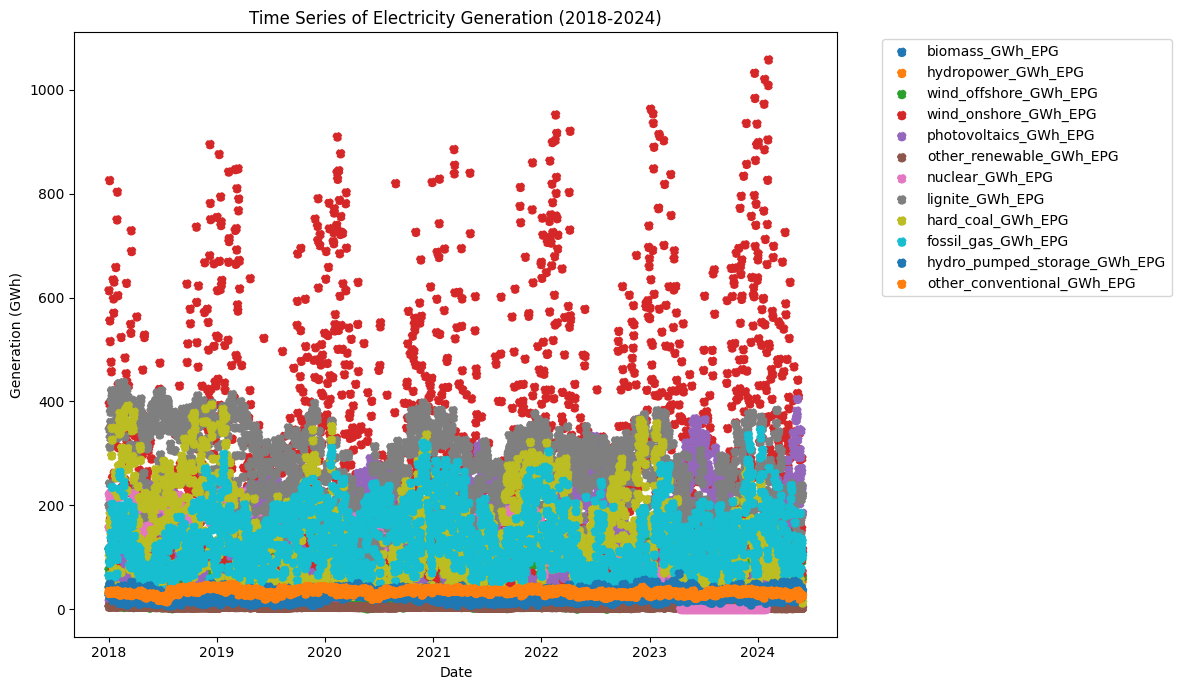

In [ ]:
import matplotlib.pyplot as plt

# Data Visualization Analysis

plt.figure(figsize=(12, 7))
for column in numeric_columns:
    plt.scatter(actual_generation['end_date'], actual_generation[column], linestyle='--', label=column)

plt.title('Time Series of Electricity Generation (2018-2024)')
plt.xlabel('Date')
plt.ylabel('Generation (GWh)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Finding the coordinates of the minimum value for each generation type
for column in numeric_columns:
    min_index = actual_generation[column].idxmin()
    min_x = actual_generation['end_date'][min_index]
    min_y = actual_generation[column][min_index]
    print(f'Minimum for {column}: Date = {min_x}, Generation = {min_y} GWh')

# Finding the coordinates of the minimum value for each generation type
for column in numeric_columns:
    max_index = actual_generation[column].idxmax()
    max_x = actual_generation['end_date'][max_index]
    max_y = actual_generation[column][max_index]
    print(f'Maximun for {column}: Date = {min_x}, Generation = {min_y} GWh')


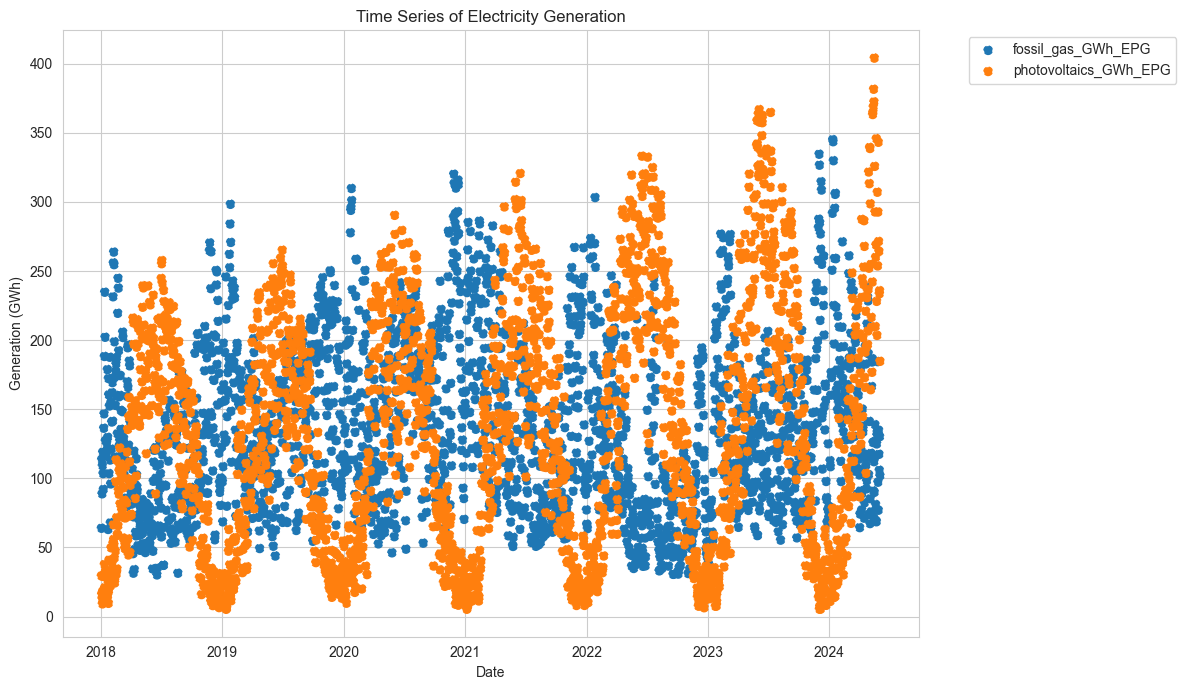

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

def plot_and_display_min_values(dataframe, variables, date_column='end_date'):
    """
    Plots the time series for selected variables and displays their minimum values.

    Parameters:
    - dataframe: pd.DataFrame containing the data
    - variables: list of column names to plot and analyze
    - date_column: name of the date column in the dataframe
    """
    # Data Visualization Analysis
    plt.figure(figsize=(12, 7))
    for column in variables:
        plt.scatter(dataframe[date_column], dataframe[column], linestyle='--', label=column)
    
    plt.title('Time Series of Electricity Generation')
    plt.xlabel('Date')
    plt.ylabel('Generation (GWh)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
 
    plt.tight_layout()
    plt.show()

# Example with two variables
selected_variables = ['fossil_gas_GWh_EPG', 'photovoltaics_GWh_EPG']

# Example usage
plot_and_display_min_values(actual_generation, selected_variables)
